# Preparing Data for Training

In [1]:
import modin.pandas as pd
import numpy as np

In [2]:
movie_ratings_df = pd.read_csv("./Dataset/ml-1m/ratings.dat", sep="::", index_col=False, engine='python')
movie_ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_ratings_df.sample(5)

Perhaps you already have a cluster running?
Hosting the HTTP server on port 45635 instead


,user_id,movie_id,rating,timestamp
661501,3989,1307,5,965600957
80071,533,208,3,976220109
942107,5684,2133,3,958608472
136335,881,2459,4,1013536905
199702,1224,2020,5,974839373


In [3]:
# count of unique movie_id, user_id
n_users = movie_ratings_df['user_id'].nunique()
n_movies = movie_ratings_df['movie_id'].nunique()
print(f"Number of unique UserID: {n_users} \nNumber of unique moviesId: {n_movies}")

Number of unique UserID: 6040 
Number of unique moviesId: 3706


In [4]:
# creating a matrix with each row containing movie ratings by user and each column containing movie name
def load_user_rating_data(movie_ratings_df, n_users, n_movies):
    data = np.zeros([n_users, n_movies], dtype=np.intc)
    movie_id_mapping = {}
    
    for user_id, movie_id, rating in zip(movie_ratings_df['user_id'], movie_ratings_df['movie_id'], movie_ratings_df['rating']):
        user_id = int(user_id) - 1
        if movie_id not in movie_id_mapping:
            movie_id_mapping[movie_id] = len(movie_id_mapping)
        
        data[user_id, movie_id_mapping[movie_id]] = rating
        
    return data, movie_id_mapping

In [5]:
data, movie_id_mapping = load_user_rating_data(movie_ratings_df, n_users, n_movies)

In [6]:
print(data)

[[3 3 4 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [3 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
dict(list(movie_id_mapping.items())[0:10])

{661: 0,
 914: 1,
 3408: 2,
 2355: 3,
 1197: 4,
 1287: 5,
 2804: 6,
 594: 7,
 919: 8,
 595: 9}

In [8]:
# analyzing data distribution for rating to identify any imbalanced class

values, counts = np.unique(data, return_counts=True)
for value, count in zip(values, counts):
    print(f"Number of rating {value}: {count}")

Number of rating 0: 21384032
Number of rating 1: 56174
Number of rating 2: 107557
Number of rating 3: 261197
Number of rating 4: 348971
Number of rating 5: 226309


As seen above most of the ratings are unknown #0. And known ones rank from Top 1 rating 4 with 35%, 26% for rating 3, 23% for rating 5, 11% rating for 2 and 6% rating for 1.

In [9]:
# fetching movie_id with the most known ratings as target movie for prediction.
print(movie_ratings_df['movie_id'].value_counts()) 

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
1908       1
1915       1
792        1
2039       1
3904       1
Name: count, Length: 3706, dtype: int64


### movie_id 2858 has most known ratings.

In [10]:
print(data[0:5])

[[3 3 4 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]]


In [11]:
# using other movie_id's as feature to train predictive model
target_movie_id = 2858
X_raw = np.delete(data, movie_id_mapping[target_movie_id], axis=1)
Y_raw = data[:, movie_id_mapping[target_movie_id]]

In [12]:
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]
print(f"shape of X: {X.shape}")
print(f"Shape of y: {Y.shape}")

shape of X: (3428, 3705)
Shape of y: (3428,)


In [13]:
# threshold set to 3 to recommend movie to user. Movie rating 3 above are considered to be recommended
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1

In [14]:
n_positive = (Y == 1).sum()
n_negative = (Y == 0).sum()
print(f"Number of positive samples: {n_positive}\nNumber of negative samples: {n_negative}")

Number of positive samples: 2853
Number of negative samples: 575


# Creating Train-Test Split

In [15]:
# creating training testing split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2742, 3705)
X_test shape: (686, 3705)
y_train shape: (2742,)
y_test shape: (686,)


# Training Naive Bayes model

In [17]:
# initializing MultinomialNB
from sklearn.naive_bayes import MultinomialNB
multnomialnb_clf = MultinomialNB(alpha=1.0, fit_prior=True) # alpha(smooting)=1 and calculating prior set to true
multnomialnb_clf.fit(X_train, y_train)

MultinomialNB()

# Testing Multinomial Naive Bayes model on testing data

In [18]:
prediction_probability = multnomialnb_clf.predict_proba(X_test)

In [19]:
# printing probability for class 0 and 1 for each testing sample
print(prediction_probability[0:10])

[[7.50487439e-23 1.00000000e+00]
 [1.01806208e-01 8.98193792e-01]
 [3.57740570e-10 1.00000000e+00]
 [1.00000000e+00 2.94095407e-16]
 [1.00000000e+00 2.49760836e-25]
 [7.62630220e-01 2.37369780e-01]
 [3.47479627e-05 9.99965252e-01]
 [2.66075292e-11 1.00000000e+00]
 [5.88493563e-10 9.99999999e-01]
 [9.71326867e-09 9.99999990e-01]]


In [20]:
prediction = multnomialnb_clf.predict(X_test)

In [21]:
prediction[:10]

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

In [22]:
clf_accuracy = multnomialnb_clf.score(X_test, y_test)

In [23]:
print(f"The accuracy of MultinomialNB model is: {clf_accuracy*100:.1f}%")

The accuracy of MultinomialNB model is: 71.6%


# Performance evaluation of MultinnomialNB model

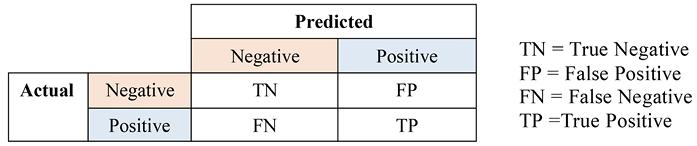                      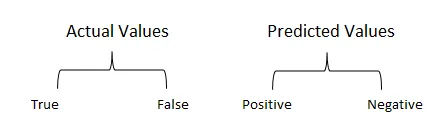

False Positive: (Type 1 Error)

Interpretation: You predicted positive and it’s false.

You predicted that a man is pregnant but he actually is not.

False Negative: (Type 2 Error)

Interpretation: You predicted negative and it’s false.

You predicted that a woman is not pregnant but she actually is.

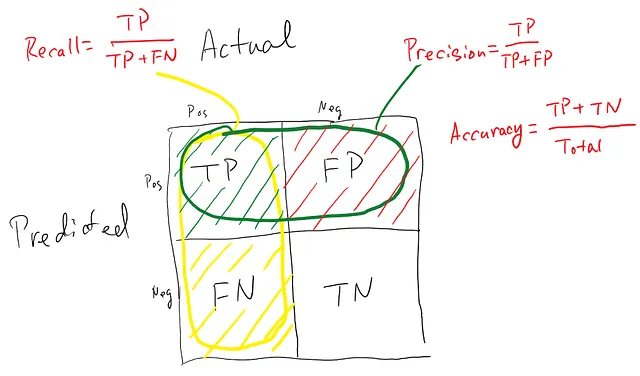

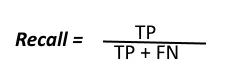  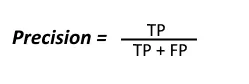  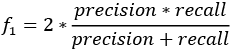

Recall:
     - The above equation can be explained by saying, from all the positive classes, how many we predicted correctly.
     - Recall should be high as possible.

Precision:
     - The above equation can be explained by saying, from all the classes we have predicted as positive, how many are actually positive.
     - Precision should be high as possible.

F1-Score:
     - It is difficult to compare two models with low precision and high recall or vice versa. So to make them comparable, we use F-Score.
     - F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, prediction, labels=[0,1])

array([[ 60,  47],
       [148, 431]])

The resulting confusion matrix, there are 47 false positive cases (where the model misinterprets a dislike as a like for a movie), and 148 false negative cases (where it fails to detect a like for a movie). Hence, classification accuracy is just the proportion of all true cases

$\large Accuracy$: $\huge \frac{TP + TN}{TP + TN + FP + FN} = \frac{60 + 431}{60 + 431 + 47 + 148} = 71.6\% $

$ \large Precision: $ $ \huge \frac{TP}{TP + FP} = \frac{431}{431 + 47} = .90 $

$ \large Recall: $ $ \huge\frac{TP}{TP + FN} = \frac{431}{431 + 148} = 0.74 $

$ \large F1-score: $ $ \huge 2*\frac{precision * recall}{precision + recall} $

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(f"precision score: {precision_score(y_test, prediction, pos_label=1)} ")
print(f"recall score: {recall_score(y_test, prediction, pos_label=1)}")
print(f"f1-score: {f1_score(y_test, prediction, pos_label=1)}")

precision score: 0.9016736401673641 
recall score: 0.7443868739205527
f1-score: 0.815515610217597


# Classification report

In [26]:
from sklearn.metrics import classification_report
report = classification_report(y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.29      0.56      0.38       107
           1       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



weighted avg is the weighted average according to the proportions of the class.

# Area Under Curve and Receiver Operating Characteristic (AUC-ROC CURVE)

 - The ROC curve is a plot of the true positive rate versus the false positive rate at various probability thresholds, ranging from 0 to 1.
 - For a testing sample, if the probability of a positive class is greater than the threshold, then a positive class is assigned; otherwise, we use a negative class.
 - The true positive rate is equivalent to recall, and the false positive rate is the fraction of negatives that are incorrectly identified as positive.

In [27]:
positive_probabilities = prediction_probability[:, 1]
thresholds = np.arange(0.0, 1.1, 0.05)
true_positives, false_positives = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(positive_probabilities, y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            # if truth and prediction both are 1
            if y == 1:
                true_positives[i] += 1
            # if truth is 0 and prediction is 1
            else:
                false_positives[i] += 1
        else:
            break

In [28]:
# calculating true and false positive rates for thresholds for (516 positive and 1191 negative testing samples)
n_positive_test = (y_test == 1).sum()
n_negative_test = (y_test == 0).sum()
true_positive_rate = [tp / n_positive_test for tp in true_positives]
false_positive_rate = [fp / n_negative_test for fp in false_positives]

In [29]:
# plotting AUC-ROC curve
import matplotlib.pyplot as plt

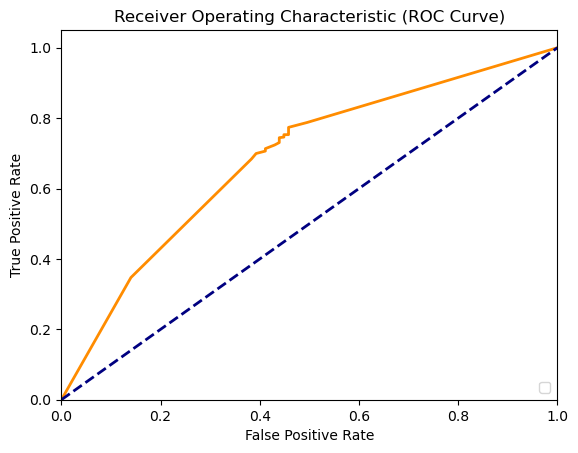

In [30]:
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC Curve)")
plt.legend(loc='lower right')
plt.show()

 - the dashed line is the baseline representing random guessing, where the true positive rate increases linearly with the false positive rate; its AUC is 0.5.
 - The solid line is the ROC plot of our model, and its AUC is somewhat less than 1.
 - In a perfect case, the true positive samples have a probability of 1, so that the ROC starts at the point with 100% true positive and 0% false positive. The AUC of such a perfect curve is 1.

In [31]:
# computing roc_auc_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, positive_probabilities)

0.6857375752586637

- What AUC value leads to the conclusion that a classifier is good? Unfortunately, there is no such “magic” number. 
- We use the following rule of thumb as general guidelines: classification models achieving an AUC of 0.7 to 0.8 are considered acceptable, 0.8 to 0.9 are great, and anything above 0.9 are superb. 
- in our case, we are only using the very sparse movie rating data. Hence, an AUC of 0.69 is actually acceptable.

# model tuning with cross-validation

In [32]:
from sklearn.model_selection import StratifiedKFold
k = 5
k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

In [33]:
# experimenting with smoothing(alpha hyperparameter) and fit_prior
smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

In [34]:
for train_indices, test_indices in k_fold.split(X, Y):
    X_train_k, X_test_k = X[train_indices], X[test_indices]
    y_train_k, y_test_k = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            optimized_mnb_clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            optimized_mnb_clf.fit(X_train_k, y_train_k)
            prediction_prob = optimized_mnb_clf.predict_proba(X_test_k)
            positive_prob = prediction_prob[:, 1]
            auc = roc_auc_score(y_test_k, positive_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)
            

In [35]:
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f"{smoothing}     {fit_prior}     {auc/k:.5f}")
        
    

1     True     0.65280
1     False     0.65274
2     True     0.65108
2     False     0.65274
3     True     0.65313
3     False     0.65322
4     True     0.65397
4     False     0.65430
5     True     0.65455
5     False     0.65448
6     True     0.65478
6     False     0.65404


In [36]:
optimized_clf = MultinomialNB(alpha=2.0, fit_prior=False)
optimized_clf.fit(X_train, y_train)
positive_probability = optimized_clf.predict_proba(X_test)[:, 1]
print(f"Auc with the best modal: {roc_auc_score(y_test, positive_probability)}")

Auc with the best modal: 0.6862056720417091
